In [ ]:
! pip install adversarial-robustness-toolbox
! pip install torch==1.13.1
! pip install torchvision==0.14.1
# python == 3.7

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from art import metrics
from torch import Tensor
import matplotlib.pyplot as plt
import torchvision
from torchvision import models, transforms

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_dataset
from art import metrics

from lime import lime_image
from skimage.segmentation import mark_boundaries
from utils import CleverScoreCalculator

/Users/anaconda3/envs/art/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
model.load_state_dict(torch.load('./cifar_net.pth'))
model.eval()


# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Create an instance of ‘CleverScoreCalculator’
clever_calculator = CleverScoreCalculator(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type='cpu'
)

In [10]:
# Test model 
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        #print(images.numpy().shape)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 40.41%


## CLEVER Score

In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

print(int(labels.numpy()))

# Predict the class using the clever_calculator model
predicted = clever_calculator.predict_class(images)
print(predicted)

# Remove the batch dimension from the image array
imge_test = np.squeeze(images.numpy(), axis=0)

# Compute and print the untargeted CLEVER score
clever_untargeted = clever_calculator.compute_untargeted_clever(imge_test)
print(f"Untargeted CLEVER score: {clever_untargeted}")

# Define a target class and compute the targeted CLEVER score
target_class = 9
clever_targeted = clever_calculator.compute_targeted_clever(imge_test, target_class)
print(f"Targeted CLEVER score for class {target_class}: {clever_targeted}")


3
3


CLEVER untargeted: 100%|██████████| 9/9 [00:01<00:00,  6.96it/s]


Untargeted CLEVER score: 5.0
Targeted CLEVER score for class 9: 6.0


## Explaining Prediction of LIME

(3, 32, 32)


100%|██████████| 1000/1000 [00:00<00:00, 4519.59it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


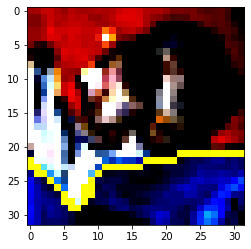

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


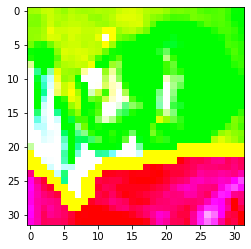

In [5]:
# Generate explanations using LIME
print(imge_test.shape)
sample = np.transpose(imge_test, (1, 2, 0))  # Convert to (height, width, channels) format

explanation = clever_calculator.explain_with_lime(sample)

# Display the explanation results
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp, mask)
plt.imshow(img_boundry1)
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp, mask)
plt.imshow(img_boundry2)
plt.show()

